In [1]:
from pathlib import Path
import xarray as xr

from spicy_snow.retrieval import retrieval_from_parameters

In [2]:
banner = xr.open_dataset(Path('/bsuhome/zacharykeskinen/scratch/spicy/SnowEx-Data/Banner_2021-03-15.nc'))

In [3]:
x_slice = slice(banner.x.min(), banner.x.max())
y_slice = slice(banner.y.max(), banner.y.min())
full_sel = xr.open_dataset(Path('/bsuhome/zacharykeskinen/scratch/idaho_full/idaho.nc')).sel(x = x_slice, y = y_slice)

In [4]:
optimal_a = 1.1
optimal_b = 2.0
optimal_c = 0.39
full_sel_bet = retrieval_from_parameters(full_sel, A = optimal_a, B = optimal_b, C = optimal_c, freezing_snow_thresh=1)

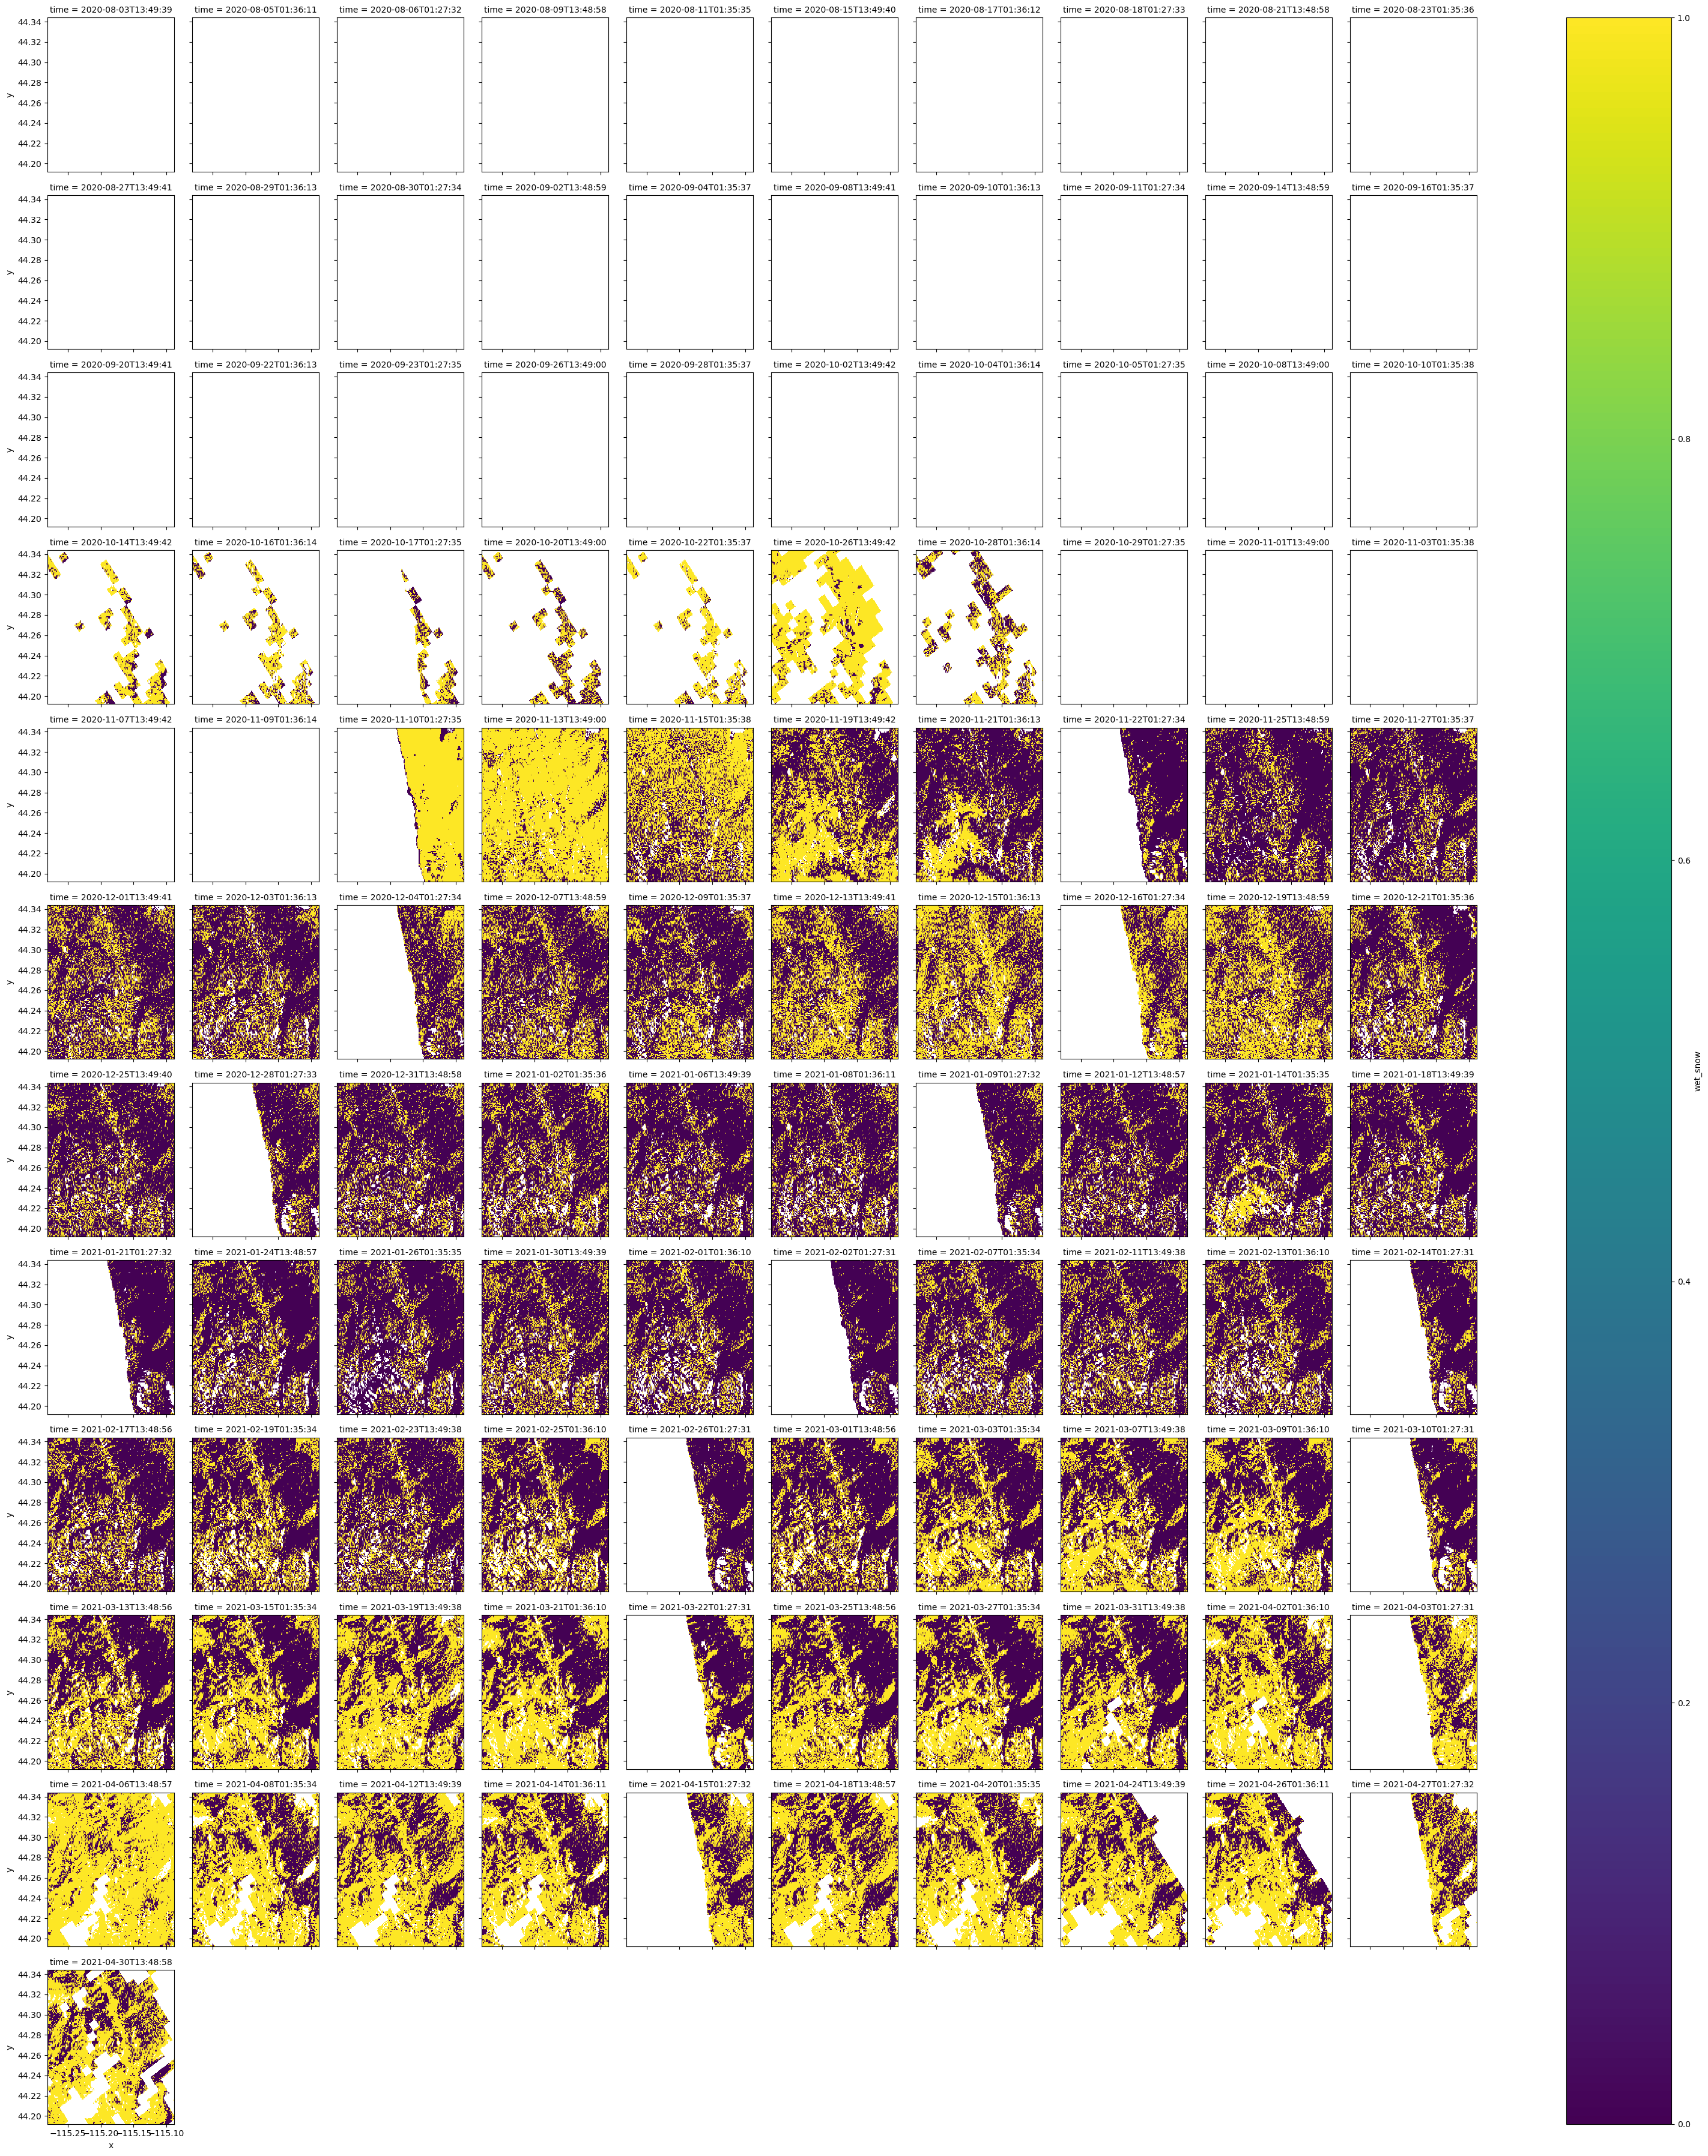

In [8]:
full_sel_bet['wet_snow'].where(full_sel_bet['ims'] == 4).plot(col = 'time', col_wrap = 10)

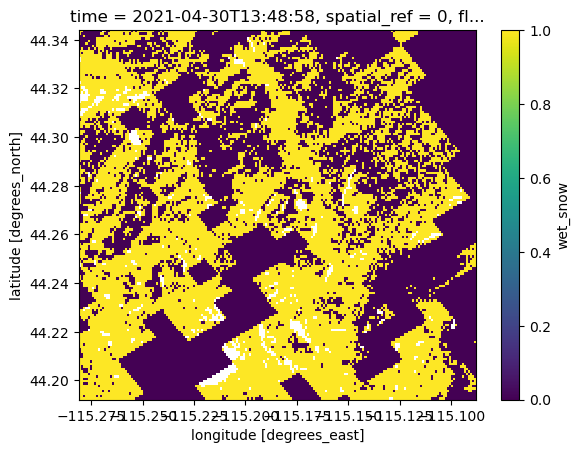

In [10]:
full_sel_bet.sel(time = '2021-04-30')['wet_snow'].plot()